## Step 1 Preprocess the data

Let's first load and preprocess the data.

In [1]:
from csv import reader
import numpy as np
import matplotlib.pyplot as plt

# Set the float formatter for numpy arrays
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Step 1.1 Load the CSV

In [2]:
def load_csv(filename: str) -> list[list[str]]:
    """Load the data from the csv file."""
    csv = []
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            csv.append(row)
    return csv

### Step 1.2 Drop the first row (table headers)

In [3]:
# Remove the first row (feature names)
csv = load_csv('data/students_dataset.csv')
data = csv[1:]

print(len(data))

4423


### Step 1.3 Encode the data

In [4]:
def encode_categorical_variables(data: list[list[str]]):
    '''Loop through the data and encode the categorical variables'''
    new_data = []
    for row in data:
        row[-1] = 0 if row[-1] == 'Dropout' else 1 if row[-1] == 'Graduate' else 2 # 2 Enrolled
        new_data.append(row)
    return new_data

# Encode the 'Target' column (0 - Dropout, 1 - Graduate, 2 - Enrolled)
data = encode_categorical_variables(data)   #data_stripped TODO

### Step 1.4 Remove noise

The students with status `Enrolled` are kind of a noise for our model, since these are students who haven't graduated yet (have some hanging exams, I guess) and yet, these students are not formally stated as `Dropouts` either. So, their final status is actually blurry and unclear. Hence, we remove them from the training dataset, so they don't confuse our model.

In [5]:
# Remove the enrolled students (keep only Dropout and Graduate)
data_filtered = [row for row in data if row[-1] != 2]

# Parse the csv strings to float numbers
data_filtered = np.array(data_filtered, dtype=np.float32)

print(data_filtered.shape)

(3629, 37)


### Step 1.5 Remove outliers
Some more noise purge.

In [6]:
def remove_outliers_iqr(data: list[list[float]], col_idx: int, k: float) -> list[list[float]]:
    '''Remove the outliers from the data'''
    column_data = [row[col_idx] for row in data]

    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    return [row for row in data if row[col_idx] >= lower_bound and row[col_idx] <= upper_bound] # Return the rows that within range

# Remove outliers
for col_idx in range(len(data_filtered[0]) - 1): # Skip the last column (Target)
    data_filtered = remove_outliers_iqr(data_filtered, col_idx, 1.1)  # We could afford to be more aggressive here, since we have enough data.

print(len(data_filtered))

731


### 1.6 Scale the data

In [7]:
def scale_data(X: list[list[float]]) -> list[list[float]]:
    """Standardize features by removing the mean and scaling to unit variance."""
    epsilon = 1e-8  # Small constant to prevent division by zero
    return (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + epsilon)

# Transform the data (every column value to be in short range between -2 and 2)
data_without_target = [row[:-1] for row in data_filtered] # Do not scale the target column   
data_filtered_scaled = scale_data(data_without_target)
data_filtered_scaled = [np.hstack((row, [data_filtered[i][-1]])) for i, row in enumerate(data_filtered_scaled)]  # Add the target column back

# Convert the list of arrays to a numpy array
data_filtered_scaled = np.array(data_filtered_scaled)

print(data_filtered_scaled[0])

[0.0000 1.0313 0.6736 1.3192 0.0000 0.0000 -0.9975 0.0000 1.3052 0.9723
 -0.4016 -1.3962 -0.6743 0.7057 0.0000 0.0000 0.0000 -0.5589 -0.9147
 0.9747 0.0000 0.0000 -0.2589 0.3688 0.2765 0.4356 0.0000 0.0000 -0.2904
 1.5581 -0.9684 -0.4986 0.0000 -0.8862 -1.5391 -1.5891 1.0000]


## Step 2 Split the data
Let's randomize and split the data into two chunks:
* `train_set` - usually, this is around 67-90% of all the data
* `test_set` - usually, a smaller subset which purpose is only to test the model accuracy after it's been trained

In our case for best results we would utilize **80% of all the data** to train the model and 20% for testing purposes.

In [8]:
def train_test_split(X: np.ndarray, test_size: float):
    '''Split the data into training and testing sets'''
    # Shuffle the data
    X = X[np.random.permutation(len(X))]

    # Split the data into training and testing sets
    X_train = X[:int(len(X) * (1 - test_size))]
    X_test = X[int(len(X) * (1 - test_size)):]

    return X_train, X_test

# Split the data into training and testing sets
X_train, X_test = train_test_split(data_filtered_scaled, test_size=0.20)

print(X_train.shape, X_test.shape)

(584, 37) (147, 37)


## Step 3 Develop an Autoencoder

Now we need to build an **Autoencoder neural network**. Basically, it's a **backpropagation** network with 3 layers, where the input and output layers have **same sizes** and the hidden middle layer has smaller size (compressed representation).

The other change is that in autoencoder model the final loss is measured as a diff between the **original input** ($x$) and the **reconstructed output**.

In [9]:
def sigmoid(X: np.ndarray):
    return 1 / (1 + np.exp(-X))

def sigmoid_derivative(X: np.ndarray):
    return X * (1 - X)

class SimpleAutoencoder:
    def __init__(self, input_size: int, hidden_size: int, learning_rate: float):
        # Initialize random weights with Xavier/Glorot initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.W2 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.b2 = np.zeros(input_size)
        self.learning_rate = learning_rate
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        # Encoder
        self.hidden = sigmoid(np.dot(X, self.W1) + self.b1)
        # Decoder
        self.output = sigmoid(np.dot(self.hidden, self.W2) + self.b2)

        return self.output
    
    def backward(self, X: np.ndarray):
        # Calculate gradients
        output_error = self.output - X
        output_delta = output_error * sigmoid_derivative(self.output)

        hidden_error = np.dot(output_delta, self.W2.T)
        hidden_delta = hidden_error * sigmoid_derivative(self.hidden)

        # Update weights and biases
        self.W2 -= self.learning_rate * np.dot(self.hidden.T, output_delta)
        self.b2 -= self.learning_rate * np.sum(output_delta)
        
        self.W1 -= self.learning_rate * np.dot(X.T, hidden_delta)
        self.b1 -= self.learning_rate * np.sum(hidden_delta)

## Step 4 Instantiate the autoencoder

Now, we have to instatiate the model and train it with the prepared data. In regard to the `hidden_layer_size` I experimented with different numbers - from $1$ to $15$. And from $10$ up to $13$ the results were the best.

In [10]:
def train_autoencoder(X: np.ndarray, autoencoder: SimpleAutoencoder, epochs: int):
    '''Train the autoencoder and return the reconstruction loss for each epoch'''
    losses = []
    
    for epoch in range(epochs):
        # Shuffle the data
        X = X[np.random.permutation(len(X))]

        # Forward pass
        output = autoencoder.forward(X)
        
        # Calculate loss (MSE)
        loss = np.mean(np.square(output - X))
        losses.append(loss)
        
        # Backward pass
        autoencoder.backward(X)
    
    return losses

The learning rate was determined after zillions of executions.

In [11]:
# Create and train autoencoder
input_size = len(X_train[0])  # All features (including the target)
hidden_size = 12  # Compressed representation
autoencoder = SimpleAutoencoder(input_size, hidden_size, learning_rate=0.002)

## Step 5 Measure the prediction accuracy

Now, we will use the model to reconstruct the data for all rows in our `test_set`. Then, we will compare the **Target** value between the original and reconstructed datasets.

NB: We consider a student a dropout prediction if the model produced a Target value between $0.50$ and $1.00$. All lower values are considered $0$ (not a dropout).

In [12]:
def check_dropout_prediction_accuracy(X_test: np.ndarray, autoencoder: SimpleAutoencoder) -> float:
    '''Check the accuracy of the reconstructed targets'''

    # Separate the test set into regular and anomaly data
    regulars = X_test.copy()
    anomalies = X_test.copy()

    # Reverse all target values in the anomaly dataset (e.g. create anomalies)
    anomalies[:, -1] = 1 - anomalies[:, -1] # 0 -> 1 and 1 -> 0

    # Get reconstructions for the test set
    regular_reconstruction_accuracy = compare_reconstructions(regulars, autoencoder) # We expect this to be high
    anomaly_reconstruction_accuracy = compare_reconstructions(anomalies, autoencoder, True) # We expect this to be low
    anomaly_detection_accuracy = 1 - anomaly_reconstruction_accuracy

    print(f"Regular reconstruction accuracy: {regular_reconstruction_accuracy:.2%}")
    print(f"Anomaly detection accuracy: {anomaly_detection_accuracy:.2%}")

    return anomaly_detection_accuracy

def compare_reconstructions(input: np.ndarray, autoencoder: SimpleAutoencoder, is_anomaly: bool = False) -> float:
    '''Compare the original data to the reconstructed data'''
    # Get reconstructions for the test set
    reconstructions = autoencoder.forward(input)

    # Extract the predicted target column and make it 0, if the value is below 0.5. Otherwise, round it up to 1
    reconstructed_targets = reconstructions[:, -1]
    reconstructed_targets = np.where(reconstructed_targets < 0.50, 0, 1)

    # Compare the original target to the reconstructed predictions
    correct_predictions = sum(reconstructed_targets == input[:, -1])

    # Calculate the accuracy in percentage
    return correct_predictions / len(input)

Now, let's run the model against our test set, which is **absolutely unknown** for the model and is **4x times bigger** than the set we used to train the model.

In [13]:
attempt = 0
# Run the trainings until we get a good enough model (93-97%)
while True:
    attempt += 1
    print(f"Attempt #{attempt} on {len(data_filtered_scaled)} rows")
    # Shuffle and split the data into training and testing sets (NB: This is important! It turns out the accuracy depends on which part of the dataset is being used for training)
    X_train, X_test = train_test_split(data_filtered_scaled, test_size=0.20)

    # Instantiate the autoencoder
    autoencoder = SimpleAutoencoder(input_size, hidden_size, learning_rate=0.003)

    # Train the model
    losses = train_autoencoder(X_train, autoencoder, epochs=10000)

    # Test accuracy
    anomaly_detection_accuracy = check_dropout_prediction_accuracy(X_test, autoencoder)

    if anomaly_detection_accuracy > 0.93:
        break

Attempt #1 on 731 rows
Regular reconstruction accuracy: 91.16%
Anomaly detection accuracy: 90.48%
Attempt #2 on 731 rows
Regular reconstruction accuracy: 94.56%
Anomaly detection accuracy: 94.56%


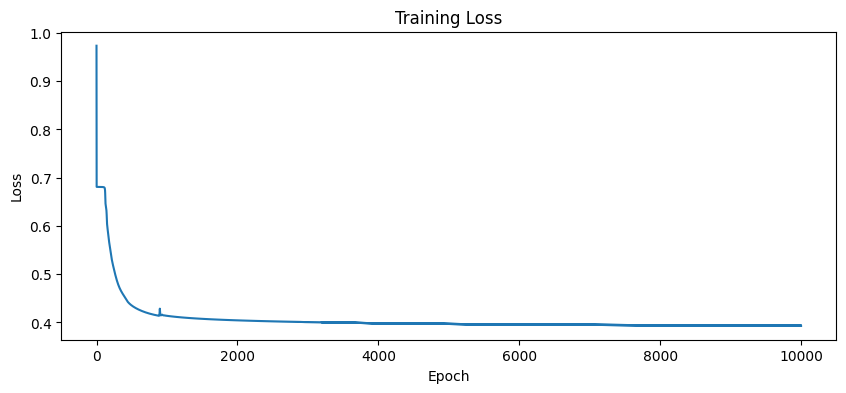

In [14]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
